In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd
from DarkNews import const
from DarkNews import plot_tools as pt
from DarkNews import Cfourvec as Cfv

from alp import plot_tools as pt
from alp import beams
from alp import models
from alp import exp
from alp.exp_dicts import EXPERIMENTS

# Fitting Pythia8 events to phenomenological parameterization

In [4]:
alp = models.ALP(0.5, 1e7)

NUMI_files = ['pythia8_events/soft_120_GeV','pythia8_events/soft_120_GeV_3e3','pythia8_events/soft_NuMI_120GeV_pt1TeV','pythia8_events/soft_NuMI_120GeV_pt1TeV_nopThatmin']
SPS_files  = ['pythia8_events/soft_400_GeV','pythia8_events/soft_400_GeV_1e4','pythia8_events/soft_SPS_400GeV_pt1TeV','pythia8_events/soft_SPS_400GeV_pt1TeV_v2','pythia8_events/soft_SPS_400GeV_pt1TeV_v3']
LHC_files  = ['pythia8_events/soft_13.6_TeV','pythia8_events/soft_13.6_TeV_1e4','pythia8_events/soft_test_LHC13.6TeV_pt1TeV_weighted']

NUMI      = exp.Experiment(NUMI_files, exp_dic=EXPERIMENTS['ICARUS'], alp=alp, savemem=False)
SPS        = exp.Experiment(SPS_files, exp_dic=EXPERIMENTS['CHARM'], alp=alp, savemem=False)
LHC  = exp.Experiment(LHC_files, exp_dic=EXPERIMENTS['FASER'], alp=alp, savemem=False)

# Concatenate all tau Pythia files into a single DataFrame and save to file

In [5]:
df_numi = exp.load_events(NUMI_files)
df_numi.to_parquet('pythia8_events/numi_120GeV.parquet', index=False)
df_sps = exp.load_events(SPS_files)
df_sps.to_parquet('pythia8_events/sps_400GeV.parquet', index=False)
df_lhc = exp.load_events(LHC_files)
df_lhc.to_parquet('pythia8_events/lhc_13.6TeV.parquet', index=False)

In [6]:
print("Total number of Pythia8 events:", NUMI.nevents, SPS.nevents, LHC.nevents)

Total number of Pythia8 events: 748677 2085248 2201103


In [7]:
NUMI_taus_plus = NUMI.p4_taus[NUMI.df_taus['pid'] == +15]
SPS_taus_plus = SPS.p4_taus[SPS.df_taus['pid'] == +15]
LHC_taus_plus = LHC.p4_taus[LHC.df_taus['pid'] == +15]
NUMI_taus_minus = NUMI.p4_taus[NUMI.df_taus['pid'] == -15]
SPS_taus_minus = SPS.p4_taus[SPS.df_taus['pid'] == -15]
LHC_taus_minus = LHC.p4_taus[LHC.df_taus['pid'] == -15]

NUMI_weights_plus = NUMI.df_taus.weights[NUMI.df_taus['pid'] == +15]
SPS_weights_plus = SPS.df_taus.weights[SPS.df_taus['pid'] == +15]
LHC_weights_plus = LHC.df_taus.weights[LHC.df_taus['pid'] == +15]
NUMI_weights_minus = NUMI.df_taus.weights[NUMI.df_taus['pid'] == -15]
SPS_weights_minus = SPS.df_taus.weights[SPS.df_taus['pid'] == -15]
LHC_weights_minus = LHC.df_taus.weights[LHC.df_taus['pid'] == -15]

# Fitting Pythia8 distributions to analytic functions

In [911]:
best_fits = {}


In [912]:
def get_xF(p4, p_beam, CoM=False):
    n_events = np.shape(p4)[0]
    p4_beam = np.zeros((n_events, 4))
    p4_beam[:, 0] = np.ones(n_events) * np.sqrt(const.m_proton**2 + p_beam**2)
    p4_beam[:, 3] = np.ones(n_events) * p_beam
    if CoM:
        p4_CM = p4
        p4_beam_CM = p4_beam
    else:
        # Boost to the center of mass frame     
        beta = p_beam / (np.sqrt(p_beam**2 + const.m_proton**2) + const.m_proton) * np.ones(n_events)
        p4_CM = Cfv.L(p4, beta)
        p4_beam_CM = Cfv.L(p4_beam, beta)

    return p4_CM[:,-1]/p4_beam_CM[:,-1]

def get_pTSQR(p4):
    pT = Cfv.getXYnorm(p4)
    return pT**2

def get_pT(p4):
    pT = Cfv.getXYnorm(p4)
    return pT

## Fit $x_F$

In [913]:
from scipy.optimize import curve_fit

def fit_function_xF(xF, r1, a_1, a_2, r2, n1, n2, r3=1, a_3=1, n3=1):
    pdf =  r1*np.exp(-a_1*abs(xF)**n1) + r2*np.exp(-a_2 * abs(xF)**n2) + r3*np.exp(-a_3 * abs(xF)**n3)
    return pdf / (np.sum(pdf[:-1]*np.diff(xF)))

p_names = ['r_1', 'a_1', 'a_2', 'r_2', 'n_1', 'n_2', 'r_3', 'a_3', 'n_3']
def find_best_fit_for_xF(xf, weights=None, xmin=0, xmax=1, bins=200):
    weights = weights / weights.sum()
    hist, bin_edges = np.histogram(xf, bins=bins, range=(xmin, xmax), weights=weights, density=False)

    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    dx_F = np.diff(bin_edges)
    hist /= dx_F
    norm = np.sum(hist*dx_F)
    hist /= norm

    sumw2, _ = np.histogram(xf, bins=bin_edges, range=(xmin, xmax), weights=weights**2, density=False)
    sumw2 /= dx_F**2
    err = np.sqrt(sumw2) / norm
    r1 = 1
    if xf.max() > 0.8:
        a_1 = 21.57
        a_2 = 315.87
        r_2 = 1521.10
        n_1 = 1.89
        n_2 = 0.48
        r_3 = 0.01
        a_3 = 16.07
        n_3 = 2.75
    else:
        a_1 = 13.42
        a_2 = 20.30
        r_2 = 2.29
        n_1 = 0.56
        n_2 = 0.22
        r_3 = 1
        a_3 = 0.14
        n_3 = 29.49
    popt, pcov = curve_fit(fit_function_xF, bin_centers[hist>0], hist[hist>0], 
                           p0=[r1, a_1, a_2, r_2, n_1, n_2, r_3, a_3, n_3], 
                           bounds=(len(p_names)*[0], 
                                   len(p_names)*[np.inf]), 
                            sigma=err[hist>0], 
                            absolute_sigma=True)
    return popt

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_28395/704721388.py:45: RuntimeWarning: divide by zero encountered in divide
  residuals = (hist - best_fit_curve) / hist
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_28395/704721388.py:47: RuntimeWarning: invalid value encountered in divide
  ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')


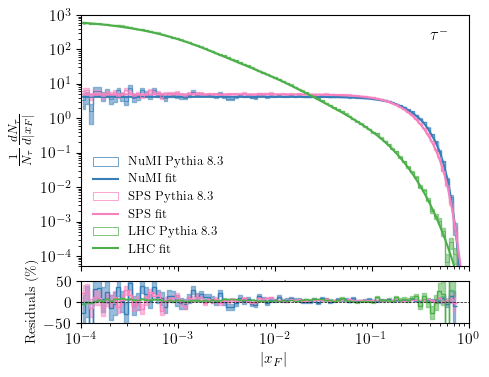

In [915]:
fig = plt.figure(figsize=(5, 4))
gs = GridSpec(2, 1, height_ratios=[3, 0.5], hspace=0.1)
ax = fig.add_subplot(gs[0])
ax_res = fig.add_subplot(gs[1], sharex=ax)
ax.loglog()

xf_numi = get_xF(NUMI_taus_minus, 120)
xf_sps = get_xF(SPS_taus_minus, 400)
xf_lhc = get_xF(LHC_taus_minus, 13_600/2, CoM=True)

NUMI_weights = NUMI_weights_minus
SPS_weights = SPS_weights_minus
LHC_weights = LHC_weights_minus

BINS = 100
xmin = 1e-4
x_F = np.geomspace(xmin, 1, BINS)
for x, weights, color, name, xmax in zip([xf_numi, xf_sps, xf_lhc], [NUMI_weights, SPS_weights, LHC_weights], pt.CB_color_cycle[:3], ['NuMI', 'SPS', 'LHC'], [0.9,0.9, 0.5]):
    dx_F = np.diff(x_F)

    weights = weights/weights.sum()

    try:
        best_fit_params = find_best_fit_for_xF(x, weights=weights, xmin=xmin, xmax=xmax, bins=x_F)
    except RuntimeError as e:
        print(f"Error fitting {name}: {e}")
        continue
    hist, bin_edges = np.histogram(x, bins=x_F, range=(xmin, xmax), weights=weights, density=False)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    hist /= dx_F
    norm = np.sum(dx_F*hist)
    hist = hist / norm  # Normalize the histogram

    sumw2, _ = np.histogram(x, bins=x_F, range=(xmin, xmax), weights=weights**2, density=False)
    sumw2 /= dx_F**2
    err = np.sqrt(sumw2) / norm
    

    _ = ax.hist(bin_centers, weights=hist, label=f'{name} Pythia 8.3', color=color, histtype='step', lw=0.5, bins=bin_edges)
    ax.fill_between(bin_centers, hist - err, hist + err, color=color, alpha=0.5, step='mid')

    best_fit_curve = fit_function_xF(bin_centers, *best_fit_params)
    _ = ax.plot(bin_centers, best_fit_curve, label=f'{name} fit', color=color)
    # Residuals
    residuals = (hist - best_fit_curve) / hist
    ax_res.hist(bin_centers, weights=residuals*100, bins=x_F, color=color, histtype='step', label=f'{name} residuals')
    ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')
    best_fits['tau_minus', name] = {}
    best_fits['tau_minus', name].update({p_name: p for p_name, p in zip(p_names, best_fit_params)})

ax.legend(loc='lower left', fontsize=9, frameon=False, ncol=1)
ax.loglog()
ax.set_ylim(0.5e-4, 1e3)
ax_res.set_ylim(-50, 50)
ax.set_xlabel(r'$|x_F|$')
ax.set_ylabel(r'$\frac{1}{N_\tau}\frac{dN_\tau}{d |x_F|}$ ', fontsize=13)
plt.setp(ax.get_xticklabels(), visible=False)

ax_res.axhline(0, color='k', lw=0.5, ls='--')
ax_res.set_ylabel('Residuals ($\%$)', fontsize=10)
ax_res.set_xlabel(r'$|x_F|$')
ax_res.set_xlim(xmin, 1)
ax.annotate(r'$\tau^-$', xy=(0.9, 0.9), xycoords='axes fraction', fontsize=12, color='k')
fig.savefig('plots/xF_fit_minus.pdf', dpi = 300, bbox_inches='tight')

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_28395/3570280144.py:45: RuntimeWarning: divide by zero encountered in divide
  residuals = (hist - best_fit_curve) / hist
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_28395/3570280144.py:47: RuntimeWarning: invalid value encountered in divide
  ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')


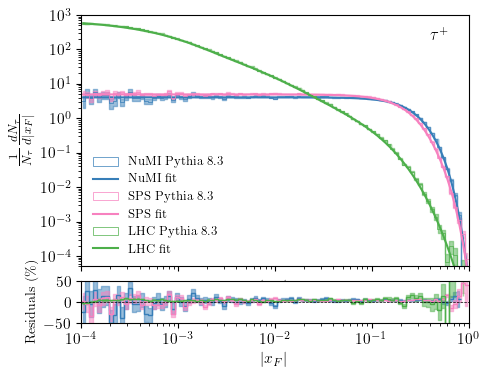

In [916]:
fig = plt.figure(figsize=(5, 4))
gs = GridSpec(2, 1, height_ratios=[3, 0.5], hspace=0.1)
ax = fig.add_subplot(gs[0])
ax_res = fig.add_subplot(gs[1], sharex=ax)

xf_numi = get_xF(NUMI_taus_plus, 120)
xf_sps = get_xF(SPS_taus_plus, 400)
xf_lhc = get_xF(LHC_taus_plus, 13_600/2, CoM=True)

NUMI_weights = NUMI_weights_plus
SPS_weights = SPS_weights_plus
LHC_weights = LHC_weights_plus

BINS = 100
xmin = 1e-4
x_F = np.geomspace(xmin, 1, BINS)
for x, weights, color, name, xmax in zip([xf_numi, xf_sps, xf_lhc], [NUMI_weights, SPS_weights, LHC_weights], pt.CB_color_cycle[:3], ['NuMI', 'SPS', 'LHC'], [0.9,0.9, 0.5]):

    dx_F = np.diff(x_F)

    weights = weights/weights.sum()

    try:
        best_fit_params = find_best_fit_for_xF(x, weights=weights, xmin=xmin, xmax=xmax, bins=x_F)
    except RuntimeError as e:
        print(f"Error fitting {name}: {e}")
        continue
    hist, bin_edges = np.histogram(x, bins=x_F, range=(xmin, xmax), weights=weights, density=False)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    hist /= dx_F
    norm = np.sum(dx_F*hist)
    hist = hist / norm  # Normalize the histogram

    sumw2, _ = np.histogram(x, bins=x_F, range=(xmin, xmax), weights=weights**2, density=False)
    sumw2 /= dx_F**2
    err = np.sqrt(sumw2) / norm
    

    _ = ax.hist(bin_centers, weights=hist, label=f'{name} Pythia 8.3', color=color, histtype='step', lw=0.5, bins=bin_edges)
    ax.fill_between(bin_centers, hist - err, hist + err, color=color, alpha=0.5, step='mid')

    best_fit_curve = fit_function_xF(bin_centers, *best_fit_params)
    _ = ax.plot(bin_centers, best_fit_curve, label=f'{name} fit', color=color)
    # Residuals
    residuals = (hist - best_fit_curve) / hist
    ax_res.hist(bin_centers, weights=residuals*100, bins=x_F, color=color, histtype='step', label=f'{name} residuals')
    ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')
    
    best_fits['tau_plus', name] = {}
    best_fits['tau_plus', name].update({p_name: p for p_name, p in zip(p_names, best_fit_params)})

ax.legend(loc='lower left', fontsize=9, frameon=False, ncol=1)
ax.loglog()
ax.set_ylim(0.5e-4, 1e3)
ax_res.set_ylim(-50, 50)
ax.set_xlabel(r'$|x_F|$')
ax.set_ylabel(r'$\frac{1}{N_\tau}\frac{dN_\tau}{d |x_F|}$ ', fontsize=13)
plt.setp(ax.get_xticklabels(), visible=False)

ax_res.axhline(0, color='k', lw=0.5, ls='--')
ax_res.set_ylabel('Residuals ($\%$)', fontsize=10)
ax_res.set_xlabel(r'$|x_F|$')
ax_res.set_xlim(xmin, 1)
ax.annotate(r'$\tau^+$', xy=(0.9, 0.9), xycoords='axes fraction', fontsize=12, color='k')
fig.savefig('plots/xF_fit_plus.pdf', dpi = 300, bbox_inches='tight')

## Fit in $p_T$

In [917]:
from scipy.stats import gamma

def fit_function_pT(p_T, g1, m1, mu1, lambda1, g2, m2, mu2, lambda2):
    pdf = g1*gamma.pdf(p_T**m1, a=mu1, scale=lambda1) + g2*gamma.pdf(p_T**m2, a=mu2, scale=lambda2)
    return pdf/np.sum(pdf[:-1]*np.diff(p_T))

p_names = ['g_1', 'm_1', 'mu_1', 'lambda_1', 'g_2', 'm_2', 'mu_2', 'lambda_2']

def find_best_fit_for_pT(pT, weights=None, xmin=0, xmax=50, bins=100):
    weights = weights / weights.sum()
    hist, bin_edges = np.histogram(pT, bins=bins, range=(xmin, xmax), weights=weights, density=False)
    dpT = np.diff(bin_edges)
    hist /= dpT
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    mask = hist > 0
    norm = np.sum(hist * dpT)
    hist /= norm  # Normalize the histogram

    sumw2, _ = np.histogram(pT, bins=bin_edges, range=(xmin, xmax), weights=weights**2, density=False)
    sumw2 /= dpT**2
    err = np.sqrt(sumw2) / norm
    
    if pT.max() > 10:
        g1 =   33.13
        m1=1    
        mu1 =   2.19
        lambda1 =   0.90
        g2 =   1.31
        mu2 =   1.27
        m2=1
        lambda2 =   4.23
    else:
        g1 =   271.91
        mu1 =   3.87
        m1 = 1
        lambda1 =   0.33
        g2 =   0.57
        mu2 =   5.05
        m2=1
        lambda2 =   83.17
    popt, pcov = curve_fit(fit_function_pT, bin_centers[mask], hist[mask], 
                           p0=[g1, m1, mu1, lambda1, g2, m2, mu2, lambda2], 
                           bounds=(8*[0], 8*[np.inf]), sigma=err[mask], absolute_sigma=True)
    return popt


/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_28395/2666020121.py:48: RuntimeWarning: divide by zero encountered in divide
  residuals = (hist - best_fit_curve) / hist
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_28395/2666020121.py:50: RuntimeWarning: invalid value encountered in divide
  ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')


Fit parameters for NuMI tau-:
g_1 =   3829.54
m_1 =   1.54
mu_1 =   1.67
lambda_1 =   0.82
g_2 =   0.55
m_2 =   0.97
mu_2 =   79.92
lambda_2 =   82.72
Fit parameters for SPS tau-:
g_1 =   1609.50
m_1 =   1.42
mu_1 =   1.73
lambda_1 =   0.88
g_2 =   0.05
m_2 =   0.01
mu_2 =   42.08
lambda_2 =   83.72
Fit parameters for LHC tau-:
g_1 =   25.04
m_1 =   0.81
mu_1 =   3.11
lambda_1 =   0.55
g_2 =   4.91
m_2 =   0.50
mu_2 =   3.35
lambda_2 =   0.34


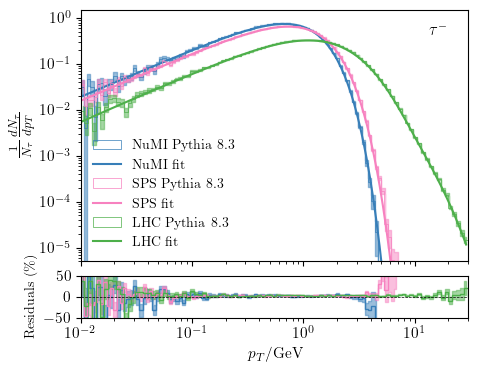

In [918]:
fig = plt.figure(figsize=(5, 4))
gs = GridSpec(2, 1, height_ratios=[3, 0.5], hspace=0.1)
ax = fig.add_subplot(gs[0])
ax_res = fig.add_subplot(gs[1], sharex=ax)


pT_numi = np.sqrt(get_pTSQR(NUMI_taus_minus))
pT_sps = np.sqrt(get_pTSQR(SPS_taus_minus))
pT_lhc = np.sqrt(get_pTSQR(LHC_taus_minus))

NUMI_weights = NUMI_weights_minus
SPS_weights = SPS_weights_minus
LHC_weights = LHC_weights_minus

BINS = 100
xmin = 1e-2

for x, weights, color, name, xmax in zip([pT_numi, pT_sps, pT_lhc], [NUMI_weights, SPS_weights, LHC_weights], pt.CB_color_cycle[:3], ['NuMI', 'SPS', 'LHC'], [8,8,30]):

    pT = np.geomspace(xmin, xmax, BINS)
    dpT = np.diff(pT)
    weights = weights/weights.sum()

    try:
        best_fit_params = find_best_fit_for_pT(x, weights=weights, xmin=xmin, xmax=xmax, bins=pT)
    except RuntimeError as e:
        print(f"Error fitting {name}: {e}")
        continue
    hist, bin_edges = np.histogram(x, bins=pT, range=(xmin, xmax), weights=weights, density=False)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    hist /= dpT
    norm = np.sum(hist * dpT)
    hist = hist / norm  # Normalize the histogram

    sumw2, _ = np.histogram(x, bins=pT, range=(0, xmax), weights=weights**2, density=False)
    sumw2 /= dpT**2
    err = np.sqrt(sumw2) / norm

    _ = ax.hist(bin_centers, weights=hist, label=f'{name} Pythia 8.3', color=color, histtype='step', lw=0.5, bins=bin_edges)
    ax.fill_between(bin_centers, hist - err, hist + err, color=color, alpha=0.5, step='mid')

    
    best_fit_curve = fit_function_pT(bin_centers, *best_fit_params)
    _ = ax.plot(bin_centers, best_fit_curve, label=f'{name} fit', color=color)
    # best_fit_curve_2 = fit_function_pT(bin_centers, *best_fit_params[:3],0,1,1,1)
    # _ = ax.plot(bin_centers, best_fit_curve_2, label=f'{name} fit', color=color)
    # Residuals
    residuals = (hist - best_fit_curve) / hist
    ax_res.hist(bin_centers, weights=residuals*100, bins=pT, color=color, histtype='step', label=f'{name} residuals')
    ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')
    print(f'Fit parameters for {name} tau-:')
    for p_name, p in zip(p_names, best_fit_params):
        print(f'{p_name} =   {p:.2f}')
    best_fits['tau_minus', name].update({p_name: p for p_name, p in zip(p_names, best_fit_params)})


ax.legend(loc='lower left', fontsize=10, frameon=False)
ax.loglog()
# ax.semilogy()
ax.set_xlim(xmin, xmax)
ax.set_ylim(5e-6, 1.5)
ax_res.set_ylim(-50, 50)
ax.set_ylabel(r'$\frac{1}{N_\tau}\frac{dN_\tau}{d p_T}$ ', fontsize=13)
plt.setp(ax.get_xticklabels(), visible=False)

ax_res.axhline(0, color='k', lw=0.5, ls='--')
ax_res.set_ylabel('Residuals ($\%$)', fontsize=10)
ax_res.set_xlabel(r'$p_T$/GeV')
ax_res.set_xlim(xmin, xmax)

ax.annotate(r'$\tau^-$', xy=(0.9, 0.9), xycoords='axes fraction', fontsize=12, color='k')
fig.savefig('plots/pT_fit_minus.pdf', dpi = 300, bbox_inches='tight')

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_28395/1917733378.py:48: RuntimeWarning: divide by zero encountered in divide
  residuals = (hist - best_fit_curve) / hist
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_28395/1917733378.py:50: RuntimeWarning: invalid value encountered in divide
  ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')


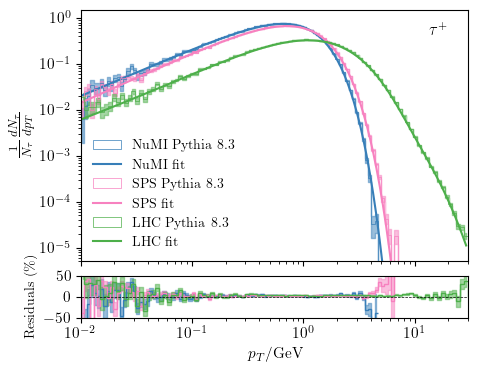

In [919]:
fig = plt.figure(figsize=(5, 4))
gs = GridSpec(2, 1, height_ratios=[3, 0.5], hspace=0.1)
ax = fig.add_subplot(gs[0])
ax_res = fig.add_subplot(gs[1], sharex=ax)


pT_numi = np.sqrt(get_pTSQR(NUMI_taus_plus))
pT_sps = np.sqrt(get_pTSQR(SPS_taus_plus))
pT_lhc = np.sqrt(get_pTSQR(LHC_taus_plus))

NUMI_weights = NUMI_weights_plus
SPS_weights = SPS_weights_plus
LHC_weights = LHC_weights_plus

BINS = 100
xmin = 1e-2

for x, weights, color, name, xmax in zip([pT_numi, pT_sps, pT_lhc], [NUMI_weights, SPS_weights, LHC_weights], pt.CB_color_cycle[:3], ['NuMI', 'SPS', 'LHC'], [8,8,30]):

    pT = np.geomspace(xmin, xmax, BINS)
    dpT = np.diff(pT)
    weights = weights/weights.sum()

    try:
        best_fit_params = find_best_fit_for_pT(x, weights=weights, xmin=xmin, xmax=xmax, bins=pT)
    except RuntimeError as e:
        print(f"Error fitting {name}: {e}")
        continue
    hist, bin_edges = np.histogram(x, bins=pT, range=(xmin, xmax), weights=weights, density=False)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    hist /= dpT
    norm = np.sum(hist * dpT)
    hist = hist / norm  # Normalize the histogram

    sumw2, _ = np.histogram(x, bins=pT, range=(0, xmax), weights=weights**2, density=False)
    sumw2 /= dpT**2
    err = np.sqrt(sumw2) / norm

    _ = ax.hist(bin_centers, weights=hist, label=f'{name} Pythia 8.3', color=color, histtype='step', lw=0.5, bins=bin_edges)
    ax.fill_between(bin_centers, hist - err, hist + err, color=color, alpha=0.5, step='mid')

    
    best_fit_curve = fit_function_pT(bin_centers, *best_fit_params)
    _ = ax.plot(bin_centers, best_fit_curve, label=f'{name} fit', color=color)
    # best_fit_curve_2 = fit_function_pT(bin_centers, *best_fit_params[:3],0,1,1,1)
    # _ = ax.plot(bin_centers, best_fit_curve_2, label=f'{name} fit', color=color)
    # Residuals
    residuals = (hist - best_fit_curve) / hist
    ax_res.hist(bin_centers, weights=residuals*100, bins=pT, color=color, histtype='step', label=f'{name} residuals')
    ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')
    
    # Best fit parameters
    best_fits['tau_plus', name].update({p_name: p for p_name, p in zip(p_names, best_fit_params)})


ax.legend(loc='lower left', fontsize=10, frameon=False)
ax.loglog()
# ax.semilogy()
ax.set_xlim(xmin, xmax)
ax.set_ylim(5e-6, 1.5)
ax_res.set_ylim(-50, 50)
ax.set_ylabel(r'$\frac{1}{N_\tau}\frac{dN_\tau}{d p_T}$ ', fontsize=13)
plt.setp(ax.get_xticklabels(), visible=False)

ax_res.axhline(0, color='k', lw=0.5, ls='--')
ax_res.set_ylabel('Residuals ($\%$)', fontsize=10)
ax_res.set_xlabel(r'$p_T$/GeV')
ax_res.set_xlim(xmin, xmax)

ax.annotate(r'$\tau^+$', xy=(0.9, 0.9), xycoords='axes fraction', fontsize=12, color='k')
fig.savefig('plots/pT_fit_plus.pdf', dpi = 300, bbox_inches='tight')

# Check generation of events following parameterization:

In [920]:
params_NuMI_plus = best_fits['tau_plus', 'NuMI']
params_SPS_plus = best_fits['tau_plus', 'SPS']
params_LHC_plus = best_fits['tau_plus', 'LHC']
params_NuMI_minus = best_fits['tau_minus', 'NuMI']
params_SPS_minus = best_fits['tau_minus', 'SPS']
params_LHC_minus = best_fits['tau_minus', 'LHC']

In [921]:
params_NuMI_plus

{'r_1': np.float64(5.4504575222750375),
 'a_1': np.float64(24.46951776810292),
 'a_2': np.float64(390.94659573124335),
 'r_2': np.float64(1439.0806584189302),
 'n_1': np.float64(2.168911596462673),
 'n_2': np.float64(0.3249562074086533),
 'r_3': np.float64(5.553225766745816),
 'a_3': np.float64(11.630248956403223),
 'n_3': np.float64(2.0547673826414026),
 'g_1': np.float64(5613.37018188074),
 'm_1': np.float64(1.500781781561357),
 'mu_1': np.float64(1.6842475618467414),
 'lambda_1': np.float64(0.7831743307138044),
 'g_2': np.float64(0.5577361831377258),
 'm_2': np.float64(0.9772185416663625),
 'mu_2': np.float64(90.01003313707982),
 'lambda_2': np.float64(84.80681905142977)}

In [ ]:
n_events = 100_000
for name, Ebeam, pT_max, params_plus, params_minus in zip(
    ['NuMI', 'SPS', 'LHC'],
    [120, 400, 13_600/2],
    [8, 8, 30],
    [params_NuMI_plus, params_SPS_plus, params_LHC_plus],
    [params_NuMI_minus, params_SPS_minus, params_LHC_minus],
):
    collider = Ebeam == 13_600/2
    df_minus = beams.generate_taus_with_custom_method(params_minus, p_beam=Ebeam, n_events=n_events, CoM=collider, pid=-15, as_dataframe=True, pT_max=pT_max)
    df_plus = beams.generate_taus_with_custom_method(params_plus,  p_beam=Ebeam, n_events=n_events, CoM=collider, pid=15, as_dataframe=True, pT_max=pT_max)
    df = pd.concat([df_minus, df_plus])
    df.to_parquet(f"tau_events/df_{name}_{n_events}_custom_parametrization.parquet")

    if name == 'NuMI':
        p0 = [EXPERIMENTS['NoVA']['x0'], EXPERIMENTS['NoVA']['y0'], EXPERIMENTS['NoVA']['L'], 3*EXPERIMENTS['NoVA']['dX']]
        # p0 = [EXPERIMENTS['MicroBooNE']['x0'], EXPERIMENTS['MicroBooNE']['y0'], EXPERIMENTS['MicroBooNE']['L'], EXPERIMENTS['MicroBooNE']['L']*0.01]
        df_minus = beams.generate_taus_with_custom_method(params_minus, n_trials=1_000_000, p_beam=Ebeam, n_events=n_events, CoM=collider, pid=-15, as_dataframe=True, pT_max=pT_max, cone_force_acceptance=p0)
        df_plus = beams.generate_taus_with_custom_method(params_plus,  n_trials=1_000_000, p_beam=Ebeam, n_events=n_events, CoM=collider, pid=15, as_dataframe=True, pT_max=pT_max, cone_force_acceptance=p0)
        df = pd.concat([df_minus, df_plus])
        df.to_parquet(f"tau_events/df_{name}_{n_events}_custom_parametrization_NoVA.parquet")


In [1110]:
alp = models.ALP(0.1, 1e8)

n_events = 100_000

SPS_files = f"tau_events/df_SPS_{n_events}_custom_parametrization.parquet"
CHARM = exp.Experiment(SPS_files, exp_dic=EXPERIMENTS['CHARM'], alp=alp, duplicate_taus=1, savemem=False)

# NUMI_files = f"tau_events/df_NuMI_{n_events}_custom_parametrization_NoVA.parquet"
# NOVA = exp.Experiment(NUMI_files, exp_dic=EXPERIMENTS['NoVA'], alp=alp, duplicate_taus=1, savemem=False)


[ 49974 124653  98493 ... 175193  17608 165910] 101586
[136702  90719  53880 ...  83749  35179 111227] 99448
[ 70867 188047  90992 ...  29212   3691  40080] 2118
[100153 114529  51235 ...    460 160864  33193] 3


In [1096]:
CHARM.tau_weights.sum(), NOVA.tau_weights.sum()

(np.float64(0.9999999999999998), np.float64(0.0051570919701735005))

(-28908.0, 28908.0)

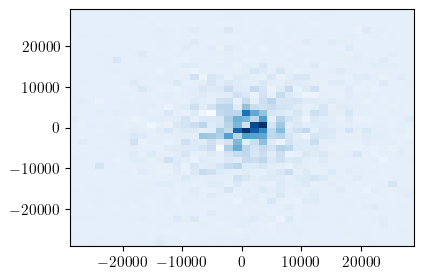

In [1095]:
N= 20
# _=plt.hist2d(CHARM.x_alp, CHARM.y_alp, weights=CHARM.weights, bins=100, density=True, cmap='Blues'),
_=plt.hist2d(NOVA.x_alp, NOVA.y_alp, weights=NOVA.weights, bins=40, range=((-N*NOVA.x0, N*NOVA.x0), (-N*NOVA.x0, N*NOVA.x0)), density=True, cmap='Blues'),
plt.xlim(-N*NOVA.x0, N*NOVA.x0)
plt.ylim(-N*NOVA.x0, N*NOVA.x0)
# _=plt.hist2d(CHARM.x_alp[CHARM.mask_alp_in_acc], CHARM.y_alp[CHARM.mask_alp_in_acc], weights=CHARM.weights[CHARM.mask_alp_in_acc], bins=30, density=True, cmap='Blues'),
# _=plt.hist(MICROBOONE_params.p4_alp_in_acc[:,0], weights=MICROBOONE_params.weights_in_acc, bins=50, density=True, alpha=0.6, color='g'),
# plt.semilogy()

In [1094]:
alp = models.ALP(0.1, 1e6)

for i in range(4):
    print(f"Event rate for MicroBooNE with custom parametrization, trial {i+1}:")
    print(f"  CHARM:", CHARM.get_event_rate(alp)/1e5)
    print(f"  NOVA:", NOVA.get_event_rate(alp)/1e5)


Event rate for MicroBooNE with custom parametrization, trial 1:
  CHARM: 0.0008575314553468082
  NOVA: 1.104534521984693e-05
Event rate for MicroBooNE with custom parametrization, trial 2:
  CHARM: 0.0012960671952571285
  NOVA: 0.0003009670475422313
Event rate for MicroBooNE with custom parametrization, trial 3:
  CHARM: 0.000764620817732733
  NOVA: 0.00011456829343646319
Event rate for MicroBooNE with custom parametrization, trial 4:
  CHARM: 0.0010220086570819466
  NOVA: -6.202416069199327e-05


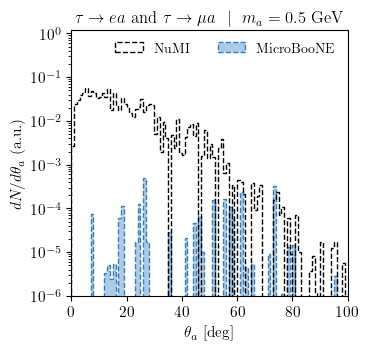

In [1088]:
fig,ax = pt.std_fig(figsize=(3.5,3.5))

alp = models.ALP(0.5, 1e7)
xunits = 1#180 / np.pi
b = np.linspace(0, 100, 101)

#######################################################
# p4, w = MICROBOONE.get_alp_events(alp=alp)
# WNORM = np.sum(w)
# ax.hist(np.arccos(Cfv.get_cosTheta(p4))*xunits, bins=b, weights=w/WNORM, label='NuMI', histtype='stepfilled', edgecolor='black', facecolor='None', linestyle='-', density=False, zorder=1.9)


#######################################################
p4, w = NOVA.get_alp_events(alp=alp)
WNORM = np.sum(w)
ax.hist(p4[:,0]*xunits, bins=b, weights=w/WNORM, label='NuMI', histtype='stepfilled', edgecolor='black', facecolor='None', linestyle='--', density=False, zorder=1.9)

p4, w = NOVA.get_alps_in_acceptance(generate_events=True, alp=alp)
ax.hist(p4[:,0]*xunits, bins=b, weights=w/WNORM, label='MicroBooNE', histtype='stepfilled', edgecolor=pt.CB_color_cycle[0], facecolor=pt.lighten_color(pt.CB_color_cycle[0], 0.4), linestyle='--', density=False, zorder=1.2)

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel(r'$\theta_{a}$ [deg]')
ax.set_ylabel(r'$dN/d \theta_a$ (a.u.)')
ax.set_xlim(0,b.max())
ax.set_ylim(1e-5, 1.2)
ax.set_yticks(np.geomspace(1e-6, 1, 7))
ax.legend(loc='upper right', fontsize=10, ncol=2)
ax.set_title(fr'$\tau \to e a$ and $\tau \to \mu a$ $\,\,\vert\,\,$ $m_a = {alp.m_a}$ GeV', fontsize=12)
fig.savefig('plots/check_acceptance_NuMI_alp_angular_spectrum.pdf', bbox_inches='tight')

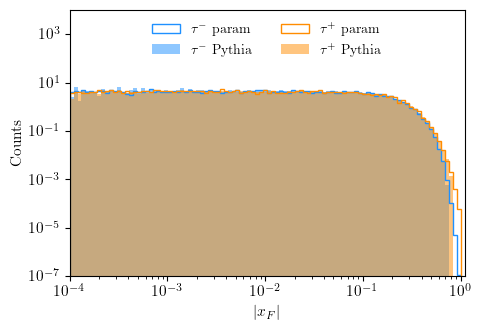

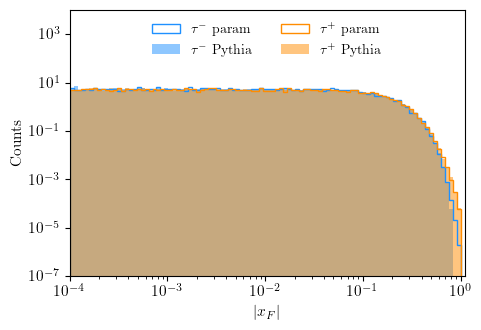

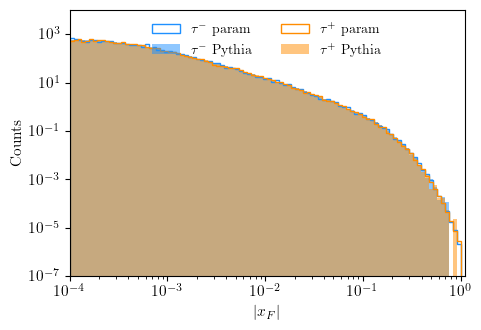

In [1033]:
n_events = 100_000
bins = np.geomspace(1e-4, 1, 100)

for name, Ebeam, Pythia_taus_plus, Pythia_taus_minus, Pythia_weights_plus, Pythia_weights_minus, params_plus, params_minus in zip(
    ['NuMI', 'SPS', 'LHC'],
    [120, 400, 13_600/2],
    [NUMI_taus_plus, SPS_taus_plus, LHC_taus_plus],
    [NUMI_taus_minus, SPS_taus_minus, LHC_taus_minus],
    [NUMI_weights_plus, SPS_weights_plus, LHC_weights_plus],
    [NUMI_weights_minus, SPS_weights_minus, LHC_weights_minus],
    [params_NuMI_plus, params_SPS_plus, params_LHC_plus],
    [params_NuMI_minus, params_SPS_minus, params_LHC_minus],
):
    fig, ax = pt.std_fig(figsize=(5, 3.5))
    
    collider = Ebeam == 13_600/2
    
    p4_minus, w_minus = beams.generate_taus_with_custom_method(params_minus, p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(abs(get_xF(p4_minus, Ebeam, CoM=collider)),weights=w_minus, bins=bins, alpha=1, histtype='step', label=r'$\tau^-$ param', density=True, color='dodgerblue')
    ax.hist(abs(get_xF(Pythia_taus_minus, Ebeam, CoM=collider)), weights=Pythia_weights_minus, bins=bins, alpha=0.5, label=r'$\tau^-$ Pythia', density=True, color='dodgerblue')

    p4_plus, w_plus = beams.generate_taus_with_custom_method(params_plus,  p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(abs(get_xF(p4_plus, Ebeam, CoM=collider)), weights=w_plus, bins=bins, alpha=1, histtype='step', label=r'$\tau^+$ param', density=True, color='darkorange')
    ax.hist(abs(get_xF(Pythia_taus_plus, Ebeam, CoM=collider)), weights=Pythia_weights_plus, bins=bins, alpha=0.5, histtype='stepfilled', label=r'$\tau^+$ Pythia', density=True, color='darkorange')

    ax.set_xlabel(r'$|x_F|$')
    ax.set_ylabel(r'Counts')
    ax.legend(loc='upper center', ncol=2)
    ax.loglog()
    ax.set_xlim(1e-4, 1.1)
    ax.set_ylim(1e-7, 1e4)
    fig.savefig('plots/xF_check_{name}.pdf', dpi=300, bbox_inches='tight')

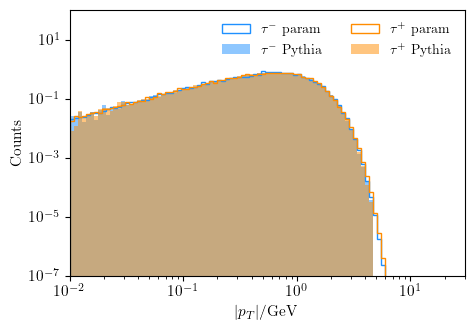

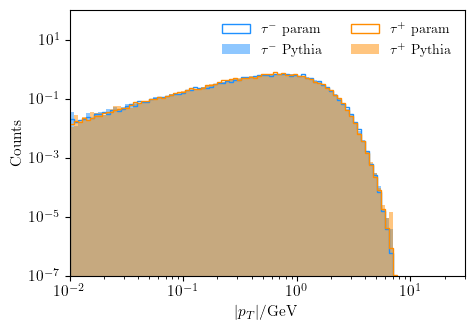

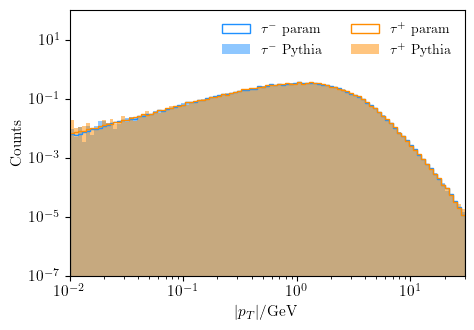

In [964]:
n_events = 100_000
bins = np.geomspace(1e-2, 30, 100)

for name, Ebeam, Pythia_taus_plus, Pythia_taus_minus, Pythia_weights_plus, Pythia_weights_minus, params_plus, params_minus in zip(
    ['NuMI', 'SPS', 'LHC'],
    [120, 400, 13_600/2],
    [NUMI_taus_plus, SPS_taus_plus, LHC_taus_plus],
    [NUMI_taus_minus, SPS_taus_minus, LHC_taus_minus],
    [NUMI_weights_plus, SPS_weights_plus, LHC_weights_plus],
    [NUMI_weights_minus, SPS_weights_minus, LHC_weights_minus],
    [params_NuMI_plus, params_SPS_plus, params_LHC_plus],
    [params_NuMI_minus, params_SPS_minus, params_LHC_minus],
):
    fig, ax = pt.std_fig(figsize=(5, 3.5))
    
    collider = Ebeam == 13_600/2
    
    p4_minus, w_minus = beams.generate_taus_with_custom_method(params_minus, p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(get_pT(p4_minus),weights=w_minus, bins=bins, alpha=1, histtype='step', label=r'$\tau^-$ param', density=True, color='dodgerblue')
    ax.hist(get_pT(Pythia_taus_minus), weights=Pythia_weights_minus, bins=bins, alpha=0.5, label=r'$\tau^-$ Pythia', density=True, color='dodgerblue')

    p4_plus, w_plus = beams.generate_taus_with_custom_method(params_plus,  p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(get_pT(p4_plus), weights=w_plus, bins=bins, alpha=1, histtype='step', label=r'$\tau^+$ param', density=True, color='darkorange')
    ax.hist(get_pT(Pythia_taus_plus), weights=Pythia_weights_plus, bins=bins, alpha=0.5, histtype='stepfilled', label=r'$\tau^+$ Pythia', density=True, color='darkorange')

    ax.set_xlabel(r'$|p_T|$/GeV')
    ax.set_ylabel(r'Counts')
    ax.legend(loc='upper right', ncol=2)
    ax.loglog()
    # ax.semilogy()
    ax.set_xlim(bins.min(), bins.max())
    ax.set_ylim(1e-7, 1e2)
    fig.savefig('plots/pT_check_{name}.pdf', dpi=300, bbox_inches='tight')

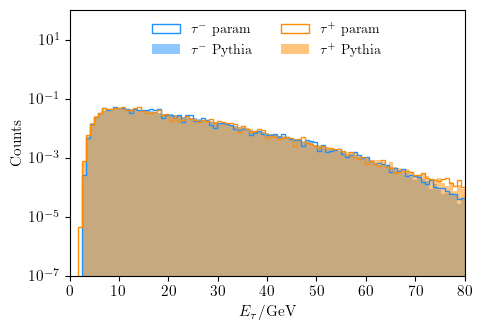

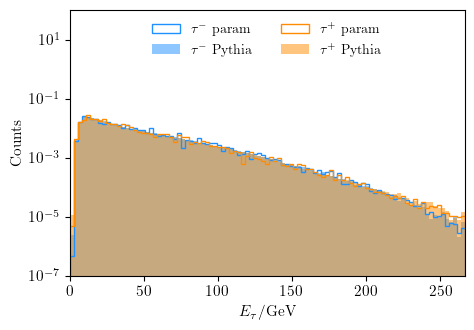

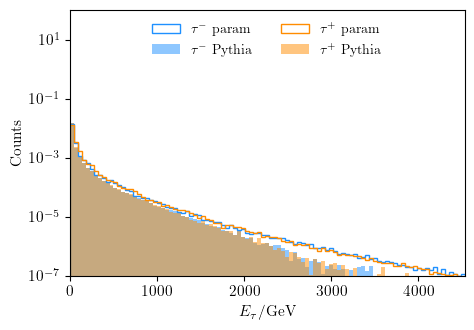

In [787]:
n_events = 100_000

for name, Ebeam, Pythia_taus_plus, Pythia_taus_minus, Pythia_weights_plus, Pythia_weights_minus, params_plus, params_minus in zip(
    ['NuMI', 'SPS', 'LHC'],
    [120, 400, 13_600/2],
    [NUMI_taus_plus, SPS_taus_plus, LHC_taus_plus],
    [NUMI_taus_minus, SPS_taus_minus, LHC_taus_minus],
    [NUMI_weights_plus, SPS_weights_plus, LHC_weights_plus],
    [NUMI_weights_minus, SPS_weights_minus, LHC_weights_minus],
    [params_NuMI_plus, params_SPS_plus, params_LHC_plus],
    [params_NuMI_minus, params_SPS_minus, params_LHC_minus],
):
    fig, ax = pt.std_fig(figsize=(5, 3.5))
    bins = np.linspace(0, Ebeam/1.5, 100)

    collider = Ebeam == 13_600/2
    
    p4_minus, w_minus = beams.generate_taus_with_custom_method(params_minus, p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(p4_minus[:,0],weights=w_minus, bins=bins, alpha=1, histtype='step', label=r'$\tau^-$ param', density=True, color='dodgerblue')
    ax.hist(Pythia_taus_minus[:,0], weights=Pythia_weights_minus, bins=bins, alpha=0.5, label=r'$\tau^-$ Pythia', density=True, color='dodgerblue')

    p4_plus, w_plus = beams.generate_taus_with_custom_method(params_plus,  p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(p4_plus[:,0], weights=w_plus, bins=bins, alpha=1, histtype='step', label=r'$\tau^+$ param', density=True, color='darkorange')
    ax.hist(Pythia_taus_plus[:,0], weights=Pythia_weights_plus, bins=bins, alpha=0.5, histtype='stepfilled', label=r'$\tau^+$ Pythia', density=True, color='darkorange')

    ax.set_xlabel(r'$E_\tau$/GeV')
    ax.set_ylabel(r'Counts')
    ax.legend(loc='upper center', ncol=2)
    ax.semilogy()
    ax.set_xlim(0,Ebeam/1.5)
    ax.set_ylim(1e-7, 1e2)
    fig.savefig('plots/Etau_check_{name}.pdf', dpi=300, bbox_inches='tight')

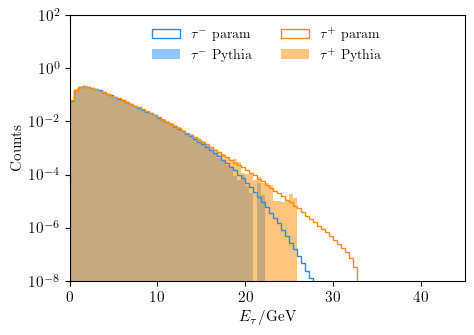

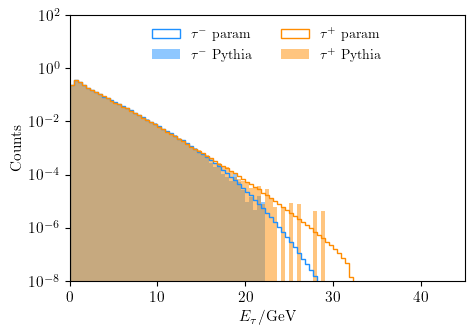

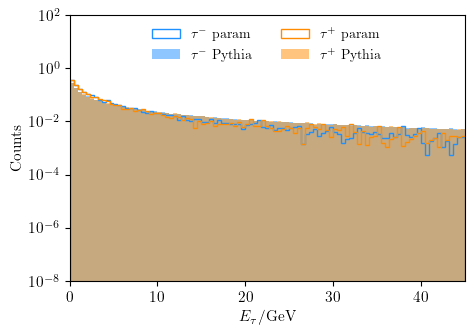

In [794]:
n_events = 10_000_000

for name, Ebeam, Pythia_taus_plus, Pythia_taus_minus, Pythia_weights_plus, Pythia_weights_minus, params_plus, params_minus in zip(
    ['NuMI', 'SPS', 'LHC'],
    [120, 400, 13_600/2],
    [NUMI_taus_plus, SPS_taus_plus, LHC_taus_plus],
    [NUMI_taus_minus, SPS_taus_minus, LHC_taus_minus],
    [NUMI_weights_plus, SPS_weights_plus, LHC_weights_plus],
    [NUMI_weights_minus, SPS_weights_minus, LHC_weights_minus],
    [params_NuMI_plus, params_SPS_plus, params_LHC_plus],
    [params_NuMI_minus, params_SPS_minus, params_LHC_minus],
):
    fig, ax = pt.std_fig(figsize=(5, 3.5))
    bins = np.linspace(0, 45, 100)

    collider = name == 'LHC'
    
    p4_minus, w_minus = beams.generate_taus_with_custom_method(params_minus, p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(np.arccos(Cfv.get_cosTheta(p4_minus))*180/np.pi,weights=w_minus, bins=bins, alpha=1, histtype='step', label=r'$\tau^-$ param', density=True, color='dodgerblue')
    ax.hist(np.arccos(Cfv.get_cosTheta(Pythia_taus_minus))*180/np.pi, weights=Pythia_weights_minus, bins=bins, alpha=0.5, label=r'$\tau^-$ Pythia', density=True, color='dodgerblue')

    p4_plus, w_plus = beams.generate_taus_with_custom_method(params_plus,  p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(np.arccos(Cfv.get_cosTheta(p4_plus))*180/np.pi, weights=w_plus, bins=bins, alpha=1, histtype='step', label=r'$\tau^+$ param', density=True, color='darkorange')
    ax.hist(np.arccos(Cfv.get_cosTheta(Pythia_taus_plus))*180/np.pi, weights=Pythia_weights_plus, bins=bins, alpha=0.5, histtype='stepfilled', label=r'$\tau^+$ Pythia', density=True, color='darkorange')

    ax.set_xlabel(r'$E_\tau$/GeV')
    ax.set_ylabel(r'Counts')
    ax.legend(loc='upper center', ncol=2)
    ax.semilogy()
    ax.set_xlim(0,bins.max())
    ax.set_ylim(1e-8, 1e2)
    fig.savefig('plots/Etau_check_{name}.pdf', dpi=300, bbox_inches='tight')

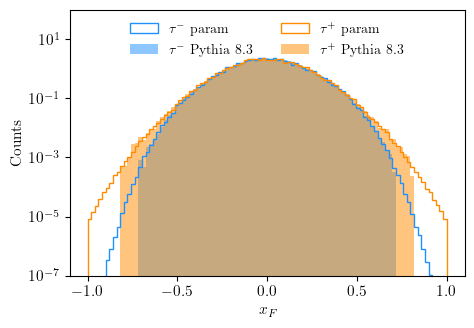

In [702]:
fig, ax = pt.std_fig(figsize=(5, 3.5))

bins = np.linspace(-1, 1, 100)

p4_numi_minus, w_numi_minus = beams.generate_taus_with_custom_method(params_NuMI_minus, p_beam=120, n_events=NUMI_weights_minus.size)
ax.hist(get_xF(p4_numi_minus, 120),weights=w_numi_minus, bins=bins, alpha=1, histtype='step', label=r'$\tau^-$ param', density=True, color='dodgerblue')
ax.hist(get_xF(NUMI_taus_minus, 120), weights=NUMI_weights_minus, bins=bins, alpha=0.5, label=r'$\tau^-$ Pythia 8.3', density=True, color='dodgerblue')

p4_numi_plus, w_numi_plus = beams.generate_taus_with_custom_method(params_NuMI_plus,  p_beam=120, n_events=NUMI_weights_plus.size)
ax.hist(get_xF(p4_numi_plus, 120), weights=w_numi_plus, bins=bins, alpha=1, histtype='step', label=r'$\tau^+$ param', density=True, color='darkorange')
ax.hist(get_xF(NUMI_taus_plus, 120), weights=NUMI_weights_plus, bins=bins, alpha=0.5, histtype='stepfilled', label=r'$\tau^+$ Pythia 8.3', density=True, color='darkorange')

ax.set_xlabel(r'$x_F$')
ax.set_ylabel(r'Counts')
ax.legend(loc='upper center', ncol=2)
ax.semilogy()
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(1e-7, 1e2)
fig.savefig('plots/xF_NuMI_check.pdf', dpi=300, bbox_inches='tight')

## Check that xF and pT are approximately uncorrelated

/opt/homebrew/Caskroom/miniforge/base/envs/darknews/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


[]

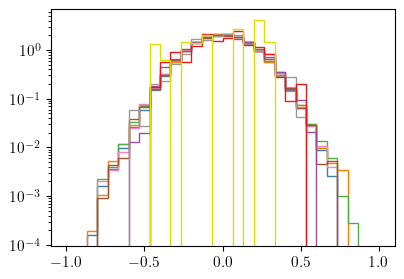

In [298]:
pT_numi = np.sqrt(get_pTSQR(NUMI_taus_plus))
xf_numi = get_xF(NUMI_taus_plus, 120)

xcuts = np.linspace(0, 5, 11)
for xmin, xmax in zip(xcuts[:-1], xcuts[1:]):
    mask = (pT_numi >= xmin) & (pT_numi < xmax)
    plt.hist(xf_numi[mask], weights=NUMI_weights_plus[mask], bins=30, range=(-1,1), histtype='step', label=f'NuMI {xmin:.2f} < pT < {xmax:.2f}', density=True)
plt.semilogy()

[]

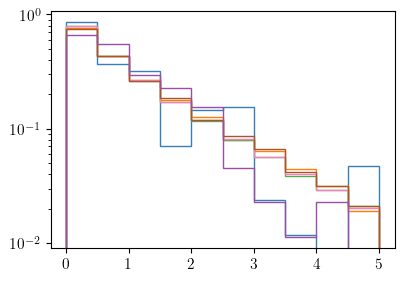

In [299]:
xf_numi = get_xF(NUMI_taus_plus, 120)
pTsqr_numi = get_pTSQR(NUMI_taus_plus)

xcuts = np.linspace(-1, 1, 7)
for xmin, xmax in zip(xcuts[:-1], xcuts[1:]):
    mask = (xf_numi >= xmin) & (xf_numi < xmax)
    plt.hist(pTsqr_numi[mask], weights=NUMI_weights_plus[mask], bins=10, range=(0, 5), histtype='step', label=f'NuMI {xmin:.2f} < xF < {xmax:.2f}', density=True)
plt.semilogy()

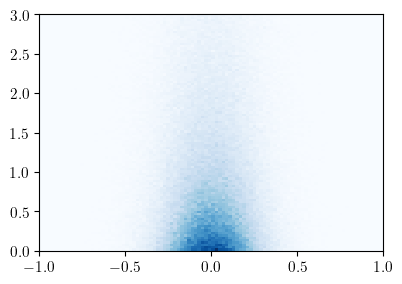

In [301]:
_=plt.hist2d(xf_numi, pTsqr_numi, weights=-np.log10(NUMI_weights_plus), bins=100, range=[(-1, 1), (0, 3)], cmap='Blues')

# Generating events with simplified parameterization of the D(s) pT spectrum

In [15]:
n_cc = 4.4
delta_n_cc = 1.6*2

b = 1.41
delta_b = 0.4*2

n_events = '1e6'

df_120 = beams.generate_taus(n_events=float(n_events), p_beam=120, n_exp=n_cc+delta_n_cc, a=0, b=b, as_dataframe=True)
df_120.to_parquet(f"tau_events/df_120GeV_{n_events}_ncentral_bcentral.parquet")

df_120 = beams.generate_taus(n_events=float(n_events), p_beam=120, n_exp=n_cc-delta_n_cc, a=0, b=b-delta_b, as_dataframe=True)
df_120.to_parquet(f"tau_events/df_120GeV_{n_events}_nlow_blow.parquet")

df_120 = beams.generate_taus(n_events=float(n_events), p_beam=120, n_exp=n_cc+delta_n_cc, a=0, b=b+delta_b, as_dataframe=True)
df_120.to_parquet(f"tau_events/df_120GeV_{n_events}_nhigh_bhigh.parquet")

df_120 = beams.generate_taus(n_events=float(n_events), p_beam=120, n_exp=n_cc-delta_n_cc, a=0, b=b+delta_b, as_dataframe=True)
df_120.to_parquet(f"tau_events/df_120GeV_{n_events}_nlow_bhigh.parquet")

df_120 = beams.generate_taus(n_events=float(n_events), p_beam=120, n_exp=n_cc+delta_n_cc, a=0, b=b-delta_b, as_dataframe=True)
df_120.to_parquet(f"tau_events/df_120GeV_{n_events}_nhigh_blow.parquet")


In [14]:
n_cc = 5.81
delta_n_cc = 0.28*2

b = 0.96
delta_b = 0.06*2

n_events = '1e6'

df_400 = beams.generate_taus(n_events=float(n_events), p_beam=400, n_exp=n_cc, a=0, b=b, as_dataframe=True)
df_400.to_parquet(f"tau_events/df_400GeV_{n_events}_ncentral_bcentral.parquet")

df_400 = beams.generate_taus(n_events=float(n_events), p_beam=400, n_exp=n_cc-delta_n_cc, a=0, b=b-delta_b, as_dataframe=True)
df_400.to_parquet(f"tau_events/df_400GeV_{n_events}_nlow_blow.parquet")

df_400 = beams.generate_taus(n_events=float(n_events), p_beam=400, n_exp=n_cc+delta_n_cc, a=0, b=b+delta_b, as_dataframe=True)
df_400.to_parquet(f"tau_events/df_400GeV_{n_events}_nhigh_bhigh.parquet")

df_400 = beams.generate_taus(n_events=float(n_events), p_beam=400, n_exp=n_cc-delta_n_cc, a=0, b=b+delta_b, as_dataframe=True)
df_400.to_parquet(f"tau_events/df_400GeV_{n_events}_nlow_bhigh.parquet")

df_400 = beams.generate_taus(n_events=float(n_events), p_beam=400, n_exp=n_cc+delta_n_cc, a=0, b=b-delta_b, as_dataframe=True)
df_400.to_parquet(f"tau_events/df_400GeV_{n_events}_nhigh_blow.parquet")

In [13]:
df = pd.read_parquet("tau_events/df_120GeV_1e6_ncentral_bcentral.parquet")
df = pd.read_parquet("tau_events/df_400GeV_1e6_ncentral_bcentral.parquet")